In [1]:
import cv2 as cv2
import numpy as np

import matplotlib.pyplot as plt

from skimage.morphology import skeletonize

# Try K-Means to segment worm

In [44]:
## Test to segment the image using a K-Means -> Do not work whitout preprocessing

path = '../full_worm/C1-180417_Dvl1&2_Odf2-injection_root_17dpa_10x_Full_1.tif'

# Load image
wormImg = cv2.imread(path)

# Open-CV open the images as BGR (BlueGreenRed),let inverse them to get an RGB
wormImg = cv2.cvtColor(wormImg, cv2.COLOR_BGR2RGB)



def kMean_Image(img, nCluster):
    # Vectorized the image (one vector per color)
    wormReshape = img.reshape(-1,3)

    # Is a float ttrasnformation required?
    wormReshape = np.float32(wormReshape)

    # Number of cluster (Worm or not worm)
    n = nCluster
    stopCriteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.1)

    # Perform K-means
    # Note: i'm not sure for the flag parameters
    ret, labels, clusters = cv2.kmeans(data = wormReshape,
                                      K = n,
                                      bestLabels = None,
                                      criteria = stopCriteria,
                                      attempts = 10, 
                                      flags = cv2.KMEANS_RANDOM_CENTERS)

    clusters = np.uint8(clusters)

    intermediateImage = clusters[labels.flatten()]
    clusteredImage = intermediateImage.reshape((wormImg.shape))

    return clusteredImage
#savePath = '../exemple/schmidtea_clustered.jpg'
#cv2.imwrite(savePath, clusteredImage)



<ipython-input-45-ee0116b4b45a>:9: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(2, len(Titles)/2, i+1), plt.imshow(Images[i], 'gray')


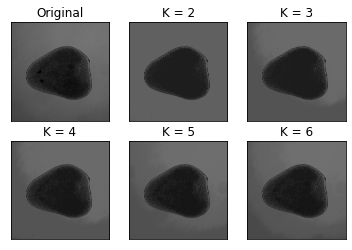

In [45]:
Images = [wormImg]
Titles = ['Original']

for i in range(5):
    Images.append(kMean_Image(wormImg, int(i+2)))
    Titles.append('K = {}'.format(i+2))
    
for i in range(len(Titles)):
    plt.subplot(2, len(Titles)/2, i+1), plt.imshow(Images[i], 'gray')
    plt.title(Titles[i])
    plt.xticks([]), plt.yticks([])

# Try image Optimization

In [46]:
img_gray  = cv2.cvtColor(wormImg, cv2.COLOR_BGR2GRAY)

# Transform into np.array
img_np = np.array(img_gray)

# Remove the median to all pixel of the image
img_median = img_np - np.median(img_gray)
img_median = np.clip(img_median, 0, np.amax(img_median))


# Remove the mean to all the pixel of the image
img_mean = img_np - np.mean(img_gray)
img_mean = np.clip(img_mean, 0, np.amax(img_mean))


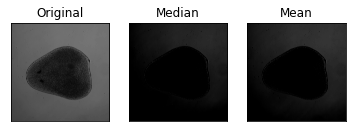

In [47]:
Titles = ['Original', 'Median', 'Mean']
Images = [img_gray, img_median, img_mean]

for i in range(len(Images)):
    plt.subplot(1, 3, i+1), plt.imshow(Images[i], 'gray')
    plt.title(Titles[i])
    plt.xticks([]), plt.yticks([])

# Try Automatic Thresholding

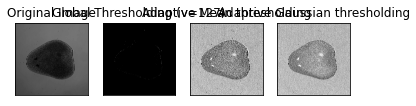

In [48]:
ret, th1 = cv2.threshold(img_gray, 127, 255, cv2.THRESH_BINARY)
th2 = cv2.adaptiveThreshold(img_gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)
th3 = cv2.adaptiveThreshold(img_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

titles = ['Original Image', 'Global Thresholding (v=127)', 'Adaptive Mean thresholding', 'Adaptive Gaussian thresholding']
images = [img_gray, th1, th2, th3]

for i in range(len(images)):
    plt.subplot(1, 4, i+1), plt.imshow(images[i], 'gray')
    plt.title(titles[i])
    plt.xticks([]), plt.yticks([])

In [42]:
def extract_worm_edge(path, nBlur, quantile = 0.01):
    wormImg = cv2.imread(path)
    img_gray  = cv2.cvtColor(wormImg, cv2.COLOR_BGR2GRAY)
    original_size = (img_gray.shape[0], img_gray.shape[1])
    
    img_gray = cv2.resize(img_gray, (600,300))
    
    blured = cv2.GaussianBlur(img_gray, (3,3), cv2.BORDER_DEFAULT)
    for i in range(nBlur):
        blured = cv2.GaussianBlur(blured, (3,3), cv2.BORDER_DEFAULT)
        
    
    cannyed = cv2.Canny(blured, np.quantile(blured, quantile), np.amax(blured)) 
    contours, _ = cv2.findContours(cannyed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    
    
    # Extract the longest contour
    max_len = 0
    idx = 0
    for i, an_edge in enumerate(contours):
        if len(an_edge) > max_len:
            max_len = len(an_edge)
            idx = i

    reshape_contour = np.reshape(contours[idx], (contours[idx].shape[0], 2))
    full_worm = np.append(reshape_contour, reshape_contour[0])

        
    ### 
    # Midline Extraction
    # Fill the worm
    img_pl = np.zeros((cannyed.shape[0],cannyed.shape[1]))
    cv2.fillPoly(img_pl,pts=contours,color=(1))
    
    
    # Skeletonize to get the midline
    skeletonized = skeletonize(img_pl)
    print(len(skeletonized))
    # Extract coordinate of skeletonized
    skeleton_flatten = skeletonized.flatten()
    midlineList = []
    Y = skeletonized.shape[0]
    X = skeletonized.shape[1]

    for idx, a_pixel in enumerate(skeleton_flatten):
        if a_pixel:
            midlineList.append((idx%X+1, idx//X+1))

    cv2.imshow('blured', blured)
    #cv2.imshow('skeleton', skeletonized)
    cv2.imshow('img_pl', img_pl)
    cv2.waitKey(0)
    
    # EDGE: X/Y formatting to plot the result        
    worm_edge = np.reshape(full_worm, (full_worm.shape[0]//2, 2))

    x_edge = []
    y_edge = []
    for coord in worm_edge:
        x_edge.append(coord[0])
        y_edge.append(coord[1])  
        
    # MIDLINE: X/Y formatting to plot the result
    x_midline = []
    y_midline = []
    for coord in midlineList:
        x_midline.append(coord[0])
        y_midline.append(coord[1])  
    
    
    ###################################################################################""
    '''newDim = (int(img_pl.shape[0]*1.1) , int(img_pl.shape[0]*1.1))
    resized = cv2.resize(img_pl, newDim, interpolation = cv2.INTER_LINEAR)
    skeleton2 = skeletonize(resized)
    marginX = (newDim[1] - img_pl.shape[1])//2
    marginY = (newDim[0] - img_pl.shape[0])//2
    skeleton2 = skeleton2[marginY:-(marginY+1), marginX: -(marginX+1)]
    skeleton2 = np.array(skeleton2, dtype='uint8')
    skeleton2 = cv2.resize(skeleton2, img_pl.shape, interpolation = cv2.INTER_LINEAR)
    
    skeleton_flatten2 = skeleton2.flatten()
    midlineList2 = []
    Y2 = skeleton2.shape[0]
    X2 = skeleton2.shape[1]

    for idx, a_pixel in enumerate(skeleton_flatten2):
        if a_pixel:
            midlineList2.append((idx%X+1, idx//X+1))
    
    x_midline2 = []
    y_midline2 = []
    for coord in midlineList2:
        x_midline2.append(coord[0])
        y_midline2.append(coord[1])  
    '''
    ########################################################################################""
    
    fig, ax = plt.subplots(figsize=(20,20))
    ax.imshow(img_gray, 'gray')
    ax.plot(x_edge, y_edge, 'red')
    ax.plot(x_midline, y_midline, 'blue')
    #ax.plot(x_midline2, y_midline2, 'green')
    plt.show()
    
    return (x_midline, y_midline), (x_edge, y_edge)

300


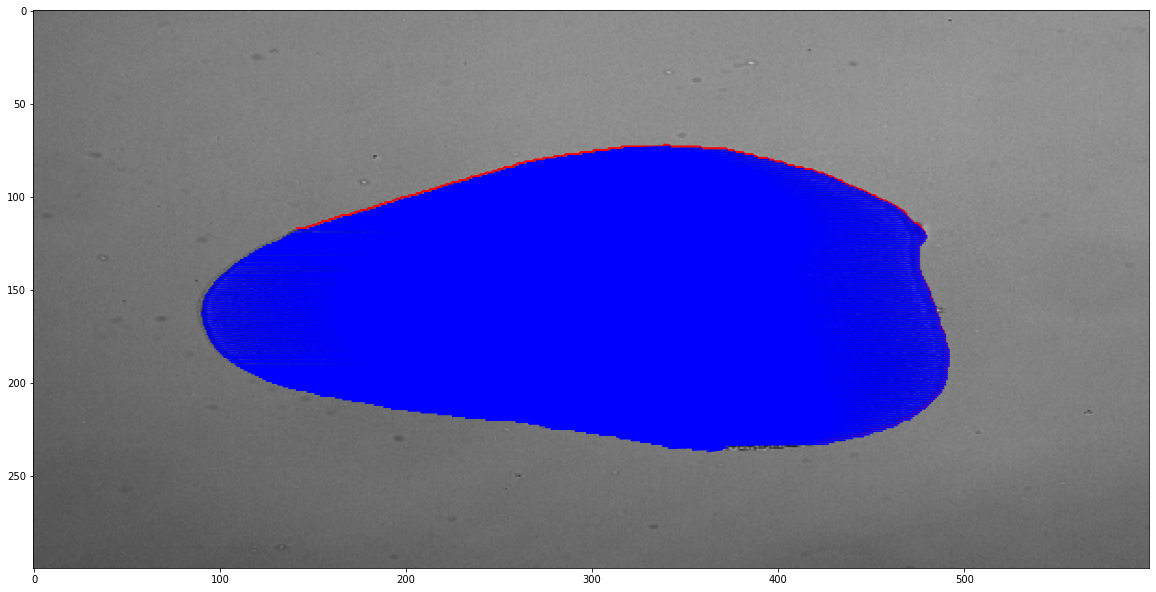

In [43]:
path = '../full_worm/C1-180417_Dvl1&2_Odf2-injection_root_17dpa_10x_Full_1.tif'
skeletonized, _  = extract_worm_edge(path, nBlur = 2, quantile = 0.1)

In [460]:
skeletonized.shape[0]*1.1

280.5

In [6]:
import numpy as np

test = [[1, 2, 3, 4], [5, 6, 7, 8], [9, 10, 11, 12], [13, 14, 15, 16]]

test_array = np.array(test)

test_array[1:3, 1:3]

array([[ 6,  7],
       [10, 11]])